<div style="background: linear-gradient(90deg, #1d479b 0%, #3498db 100%);
    padding: 40px;
    border-radius: 10px;
    box-shadow: 0 4px 15px rgba(0,0,0,0.1);
    text-align: center;
    color: white;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    <h1 style="margin: 0; font-size: 2.8em; font-weight: 700; text-transform: uppercase; letter-spacing: 2px;">
        Machine learning Project: Seattle Energy
    </h1>
    <hr style="width: 100px; border: 2px solid #f1c40f; margin: 20px auto;">
    <p style="font-size: 1.2em; font-style: italic; opacity: 0.9; text-align: center;">
    Analyse et Prédiction de la Consommation Énergétique des Bâtiments Non-Résidentiels
    </p>
</div>

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ==============================================================================
# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES
# ==============================================================================

# Chargement de la base de données nettoyée et enrichie
DATA_URL = "https://raw.githubusercontent.com/Luck-John/Projet-ML-Prediction-of-building-energy/refs/heads/master/data/processed/seattle_energy_cleaned_final.csv"
df = pd.read_csv(DATA_URL)

# Définition de la variable cible (Échelle Logarithmique)
target_col = 'SiteEnergyUse_log'

# Liste des variables à exclure pour éviter le "Data Leakage" ou la redondance
# - SiteEnergyUse(kBtu) / EnergyIntensity : Variables cibles brutes ou dérivées
# - PropertyGFATotal : Exclue car nous utilisons sa transformation log 'PropertyGFATotal_log'
# - Identifiants et texte brut : Variables non prédictives
cols_to_exclude = [
    'SiteEnergyUse(kBtu)', 'SiteEnergyUse_log',
    'EnergyIntensity', 'EnergyIntensity_Log',
    'PropertyGFATotal',
    'OSEBuildingID', 'DataYear',
    'ListOfAllPropertyUseTypes', 'ListOfAllPropertyUseTypes_clean'
]

# Extraction des caractéristiques (X) et de la cible (y)
X = df.drop(columns=[c for c in cols_to_exclude if c in df.columns], errors='ignore')
y = df[target_col]

# ==============================================================================
# 2. SÉPARATION DES JEUX D'ENTRAÎNEMENT ET DE TEST
# ==============================================================================

# Découpage : 80% pour l'entraînement (Train) et 20% pour l'évaluation finale (Test)
# Le paramètre random_state=42 garantit la reproductibilité des résultats.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Affichage des dimensions pour validation
print(f"✅ Chargement terminé.")
print(f"-> Taille du jeu d'entraînement : {X_train.shape[0]} échantillons, {X_train.shape[1]} variables.")
print(f"-> Taille du jeu de test        : {X_test.shape[0]} échantillons.")

Dimensions Train : (1242, 20)
,Dimensions Test  : (311, 20)


In [55]:
#Installer le module pour l'encodage
!pip install category_encoders

,Requirement already satisfied: numpy>=1.14.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (2.0.2)
,Requirement already satisfied: pandas>=1.0.5 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (2.2.2)
,Requirement already satisfied: patsy>=0.5.1 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (1.0.2)
,Requirement already satisfied: scikit-learn>=1.6.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (1.6.1)
,Requirement already satisfied: scipy>=1.0.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (1.16.3)
,Requirement already satisfied: statsmodels>=0.9.0 in /usr/local/lib/python3.12/dist-packages (from category_encoders) (0.14.6)
,Requirement already satisfied: python-dateutil>=2.8.2 in /usr/local/lib/python3.12/dist-packages (from pandas>=1.0.5->category_encoders) (2.9.0.post0)
,Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.12/dist-packages (from pandas>=1.0

In [60]:
import category_encoders as ce

# ==============================================================================
# 2. ENCODAGE DES VARIABLES CATÉGORIELLES (TARGET ENCODING)
# ==============================================================================

# Le Target Encoding remplace chaque catégorie par la moyenne de la variable cible
# (SiteEnergyUse_log) pour cette catégorie. C'est particulièrement efficace pour
# les variables à forte cardinalité (ex: codes postaux, types d'usage).

print("\n>>> Phase d'encodage des variables qualitatives...")

# Identification automatique des colonnes catégorielles (object et category)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"-> Variables identifiées pour l'encodage : {cat_cols}")

# Initialisation du TargetEncoder
# - smoothing=10 : Réduit l'impact des catégories à faible effectif pour éviter le surapprentissage (overfitting).
# - handle_unknown='value' : Assigne la moyenne globale aux catégories absentes du jeu d'entraînement.
encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10, handle_unknown='value')

# 1. Ajustement et transformation sur le jeu d'entraînement
# L'encodeur apprend la relation entre les catégories de X et la cible y_train.
X_train_final = encoder.fit_transform(X_train, y_train)

# 2. Transformation sur le jeu de test
# On applique les correspondances apprises au jeu de test (sans fuite d'information).
X_test_final = encoder.transform(X_test)

# ==============================================================================
# VALIDATION DE L'ENCODAGE
# ==============================================================================

print("✅ Encodage terminé avec succès.")
print(f"-> Dimensions finales du jeu d'entraînement : {X_train_final.shape}")

# Vérification du résultat (Toutes les colonnes doivent être numériques)
if X_train_final.select_dtypes(include=['object']).columns.empty:
    print("-> Toutes les variables sont désormais converties au format numérique.")
else:
    print("-> Attention : certaines variables catégorielles n'ont pas été encodées.")

# Aperçu des premières lignes du jeu d'entraînement encodé
X_train_final.head()


,>>> Phase d'encodage des variables qualitatives...
,-> Variables identifiées pour l'encodage : ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'Surface_Cluster']
,✅ Encodage terminé avec succès.
,-> Dimensions finales du jeu d'entraînement : (1242, 20)
,-> Toutes les variables sont désormais converties au format numérique.


,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,BuildingAge,PropertyGFATotal_log,Distance_to_Center,Neighborhood_Cluster,Is_Downtown,Rotated_Lat,Rotated_Lon,Surface_Cluster
1289,14.901364,15.354249,98101.0,7,14.909502,1.0,6,26082,69035,15.354249,69035.0,1.0,47,11.462863,0.850214,3,1,102.397958,-82.132107,16.151353
1233,14.901364,15.071445,98108.0,2,14.389393,1.0,3,0,36140,14.939030,34733.0,72.0,54,10.495156,7.292561,2,0,102.333233,-82.164580,14.330607
1208,14.901364,15.354249,98133.0,5,14.790757,1.0,6,0,244500,15.354249,244500.0,100.0,7,12.406971,10.647423,1,0,102.472713,-82.084386,16.151353
1253,14.901364,14.674171,98122.0,3,14.747647,4.0,2,0,28500,14.674171,31100.0,92.0,7,10.257659,3.697115,0,0,102.381290,-82.093776,14.330607
382,14.901364,15.071445,98125.0,5,14.790757,0.0,2,0,98539,15.031596,98539.0,72.0,47,11.498208,11.520899,1,0,102.476767,-82.076168,16.151353


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement et validation
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Algorithmes de Régression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Métriques de performance
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

# Configuration de l'affichage pour une meilleure lisibilité des DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# ==============================================================================
# FONCTIONS UTILITAIRES POUR L'ÉVALUATION ET LE SCÉNARIO
# ==============================================================================

def evaluate_performance(model, X, y_log, dataset_name="Test"):
    """
    Calcule et retourne les métriques de performance sur les échelles
    logarithmique et réelle.
    """
    # Prédictions sur l'échelle Log
    y_pred_log = model.predict(X)

    # Transformation inverse pour évaluation sur l'échelle réelle (kBTU)
    y_real = np.exp(y_log)
    y_pred_real = np.exp(y_pred_log)

    # Calcul des métriques techniques (Échelle Log)
    rmse_log = np.sqrt(mean_squared_error(y_log, y_pred_log))
    r2_log = r2_score(y_log, y_pred_log)

    # Calcul des métriques métiers (Échelle Réelle)
    rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))
    mae_real = mean_absolute_error(y_real, y_pred_real)
    mape_real = mean_absolute_percentage_error(y_real, y_pred_real)
    r2_real = r2_score(y_real, y_pred_real)

    prefix = dataset_name + "_"

    return {
        f'{prefix}RMSE_Log': rmse_log,
        f'{prefix}R2_Log': r2_log,
        f'{prefix}RMSE_Real': rmse_real,
        f'{prefix}MAE_Real': mae_real,
        f'{prefix}MAPE_Real': mape_real, # Métrique pivot pour la précision relative
        f'{prefix}R2_Real': r2_real
    }

def prepare_xy_for_scenario(X_train, X_test, use_energy_star):
    """
    Gère l'inclusion ou l'exclusion de la variable 'ENERGYSTARScore'
    pour comparer l'impact de ce score sur les performances du modèle.
    """
    if not use_energy_star and 'ENERGYSTARScore' in X_train.columns:
        # Suppression de la colonne si le scénario l'exige
        return X_train.drop(columns=['ENERGYSTARScore']), X_test.drop(columns=['ENERGYSTARScore'])

    return X_train.copy(), X_test.copy()

In [43]:
def train_linear_models(X_train_src, X_test_src, y_train, y_test, use_energy_star=False):
    """
    Entraîne et optimise une batterie de modèles linéaires via GridSearchCV.
    Compare l'impact de l'utilisation du score ENERGY STAR sur les performances.
    """
    scenario_label = "AVEC EnergyStar" if use_energy_star else "SANS EnergyStar"
    print(f"--- Entraînement : Famille Linéaire [{scenario_label}] ---")

    # 1. Sélection des données selon le scénario
    X_train_curr, X_test_curr = prepare_xy_for_scenario(X_train_src, X_test_src, use_energy_star)

    # 2. Pipeline de Pré-traitement
    # Note : La standardisation est indispensable pour les modèles régularisés (Ridge, Lasso, etc.)
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # 3. Définition des algorithmes et de leurs grilles d'hyperparamètres
    models_config = {
        'LinearRegression': (LinearRegression(), {}),

        'Ridge': (Ridge(random_state=42), {
            'model__alpha': [0.01, 0.1, 1, 10, 50, 100]
        }),

        'Lasso': (Lasso(random_state=42, max_iter=5000), {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1]
        }),

        'ElasticNet': (ElasticNet(random_state=42, max_iter=5000), {
            'model__alpha': [0.001, 0.01, 0.1, 1],
            'model__l1_ratio': [0.1, 0.5, 0.9]
        }),

        'SVM_Linear': (LinearSVR(random_state=42, max_iter=10000, dual='auto'), {
            'model__C': [0.01, 0.1, 1, 10, 100]
        })
    }

    results = []

    # 4. Exécution de la recherche d'hyperparamètres (GridSearchCV)
    for name, (model, params) in models_config.items():
        # Assemblage du pipeline complet (Preprocess + Modèle)
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Optimisation par validation croisée (CV=5)
        grid = GridSearchCV(
            pipe,
            params,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid.fit(X_train_curr, y_train)

        # Évaluation des performances sur les jeux Train et Test
        metrics_train = evaluate_performance(grid.best_estimator_, X_train_curr, y_train, "Train")
        metrics_test = evaluate_performance(grid.best_estimator_, X_test_curr, y_test, "Test")

        # Agrégation des résultats
        res = {
            'Scenario': 'With Score' if use_energy_star else 'No Score',
            'Model': name
        }
        res.update(metrics_train)
        res.update(metrics_test)
        results.append(res)

    return pd.DataFrame(results)

In [44]:
def train_simple_nonlinear(X_train_src, X_test_src, y_train, y_test, use_energy_star=False):
    """
    Entraîne et optimise des modèles non-linéaires de base (KNN et Arbres de décision).
    Évalue la performance selon le scénario d'inclusion ou non du score ENERGY STAR.
    """
    scenario_label = "AVEC EnergyStar" if use_energy_star else "SANS EnergyStar"
    print(f"--- Entraînement : Modèles Non-Linéaires Simples [{scenario_label}] ---")

    # 1. Préparation des jeux de données selon le scénario
    X_train_curr, X_test_curr = prepare_xy_for_scenario(X_train_src, X_test_src, use_energy_star)

    # 2. Pipeline de pré-traitement
    # Note : Le scaling est critique pour KNN (calcul de distances).
    # Bien que non requis pour les arbres, il est maintenu pour l'homogénéité du pipeline.
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # 3. Configuration des modèles et des grilles d'exploration
    models_config = {
        'KNN': (KNeighborsRegressor(), {
            'model__n_neighbors': [3, 5, 10, 15, 20],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]  # 1: Manhattan, 2: Euclidienne
        }),

        'DecisionTree': (DecisionTreeRegressor(random_state=42), {
            'model__max_depth': [5, 10, 15, 20, None],
            'model__min_samples_leaf': [2, 5, 10, 20],
            'model__min_samples_split': [2, 10]
        })
    }

    results = []

    # 4. Entraînement et validation croisée
    for name, (model, params) in models_config.items():
        # Construction du pipeline de l'estimateur
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Optimisation des hyperparamètres
        grid = GridSearchCV(
            pipe,
            params,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid.fit(X_train_curr, y_train)

        # Calcul des métriques de performance
        metrics_train = evaluate_performance(grid.best_estimator_, X_train_curr, y_train, "Train")
        metrics_test = evaluate_performance(grid.best_estimator_, X_test_curr, y_test, "Test")

        # Consolidation des résultats
        res = {
            'Scenario': 'With Score' if use_energy_star else 'No Score',
            'Model': name
        }
        res.update(metrics_train)
        res.update(metrics_test)
        results.append(res)

    return pd.DataFrame(results)

In [45]:
def train_ensemble_models(X_train_src, X_test_src, y_train, y_test, use_energy_star=False):
    """
    Entraîne et optimise des modèles ensemblistes (Bagging et Boosting).
    Sauvegarde les meilleurs hyperparamètres pour une utilisation ultérieure dans un Stacking.
    """
    scenario_label = "AVEC EnergyStar" if use_energy_star else "SANS EnergyStar"
    print(f"--- Entraînement : Famille Ensembliste [{scenario_label}] ---")

    # 1. Préparation des données selon le scénario
    X_train_curr, X_test_curr = prepare_xy_for_scenario(X_train_src, X_test_src, use_energy_star)

    # 2. Configuration du pré-traitement
    # Note : Les modèles d'arbres gèrent nativement les échelles ; seul l'imputation est requise.
    preprocessor = SimpleImputer(strategy='median')

    # 3. Définition des algorithmes et des grilles d'hyperparamètres
    models_config = {
        'RandomForest': (
            RandomForestRegressor(random_state=42),
            {
                'model__n_estimators': [100, 200, 300, 500],
                'model__max_depth': [10, 20, 30, None],
                'model__min_samples_leaf': [1, 2, 4]
            }
        ),
        'ExtraTrees': (
            ExtraTreesRegressor(random_state=42),
            {
                'model__n_estimators': [100, 300, 500],
                'model__max_depth': [10, 20, None],
                'model__min_samples_leaf': [1, 2]
            }
        ),
        'XGBoost': (
            XGBRegressor(random_state=42, objective='reg:squarederror'),
            {
                'model__n_estimators': [100, 300, 500],
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__max_depth': [3, 6, 9],
                'model__subsample': [0.8, 1.0]
            }
        ),
        'LightGBM': (
            LGBMRegressor(random_state=42, verbose=-1),
            {
                'model__n_estimators': [100, 300, 500],
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__num_leaves': [20, 31, 50, 100]
            }
        ),
        'HistGradientBoosting': (
            HistGradientBoostingRegressor(random_state=42),
            {
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__max_iter': [100, 200, 300],
                'model__max_depth': [None, 10, 20],
                'model__l2_regularization': [0, 0.1]
            }
        )
    }

    results = []
    best_params_storage = {}

    # 4. Processus d'optimisation et d'évaluation
    for name, (model, params) in models_config.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Utilisation d'une validation croisée robuste (CV=5)
        grid = GridSearchCV(
            pipe, params, cv=5,
            scoring='neg_root_mean_squared_error', n_jobs=-1
        )

        grid.fit(X_train_curr, y_train)

        # --- Extraction des hyperparamètres optimaux ---
        # Nettoyage des clés (suppression du préfixe 'model__') pour réutilisation directe
        raw_params = grid.best_params_
        clean_params = {k.replace('model__', ''): v for k, v in raw_params.items()}
        best_params_storage[name] = clean_params

        # Évaluation sur les échelles Log et Réelle
        metrics_train = evaluate_performance(grid.best_estimator_, X_train_curr, y_train, "Train")
        metrics_test = evaluate_performance(grid.best_estimator_, X_test_curr, y_test, "Test")

        # Compilation des résultats pour le tableau comparatif
        res = {
            'Scenario': 'With Score' if use_energy_star else 'No Score',
            'Model': name,
            'Best_Params_Raw': str(raw_params)
        }
        res.update(metrics_train)
        res.update(metrics_test)
        results.append(res)

    # Retourne le DataFrame de synthèse et le dictionnaire des configurations optimales
    return pd.DataFrame(results), best_params_storage

In [46]:
# ==============================================================================
# EXÉCUTION DU PIPELINE D'ENTRAÎNEMENT ET CONSOLIDATION
# ==============================================================================

# 1. Évaluation des Modèles Linéaires (Baseline)
print("Étape 1/3 : Entraînement des modèles linéaires...")
df_linear_no = train_linear_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=False)
df_linear_yes = train_linear_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=True)

# 2. Évaluation des Modèles Non-Linéaires de base
print("\nÉtape 2/3 : Entraînement des modèles non-linéaires simples...")
df_simple_no = train_simple_nonlinear(X_train_final, X_test_final, y_train, y_test, use_energy_star=False)
df_simple_yes = train_simple_nonlinear(X_train_final, X_test_final, y_train, y_test, use_energy_star=True)

# 3. Évaluation des Modèles Ensemblistes et extraction des hyperparamètres optimaux
print("\nÉtape 3/3 : Entraînement des modèles ensemblistes...")

# Scénario SANS EnergyStar : Seuls les scores de performance sont conservés
df_ensemble_no, _ = train_ensemble_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=False)

# Scénario AVEC EnergyStar : On extrait les hyperparamètres (best_params_yes) pour le Stacking ultérieur
df_ensemble_yes, best_params_yes = train_ensemble_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=True)


# ==============================================================================
# SYNTHÈSE GLOBALE DES RÉSULTATS
# ==============================================================================

# Fusion de tous les tableaux de résultats pour comparaison exhaustive
all_results = pd.concat([
    df_linear_no, df_linear_yes,
    df_simple_no, df_simple_yes,
    df_ensemble_no, df_ensemble_yes
], ignore_index=True)

# Sélection des indicateurs clés pour le classement final
cols_to_show = [
    'Scenario', 'Model',
    'Test_MAPE_Real',  # Indicateur d'erreur relative (priorité métier)
    'Test_R2_Real',    # Coefficient de détermination sur l'échelle réelle
    'Test_R2_Log',     # Performance sur l'échelle logarithmique
    'Train_R2_Real'    # Indicateur de contrôle du surapprentissage (overfitting)
]

print("\n" + "="*80)
print("CLASSEMENT FINAL DES MODÈLES (PAR MAPE CROISSANTE)")
print("="*80)
# Tri par MAPE (la plus petite erreur en premier)
summary_display = all_results[cols_to_show].sort_values(by='Test_MAPE_Real', ascending=True)
print(summary_display.round(4).to_string(index=False))

# Vérification technique des paramètres pour la phase de Stacking
print(f"\n✅ Paramètres optimaux sauvegardés pour : {list(best_params_yes.keys())}")

1. Modèles Linéaires...
,
,>>> [LINEAR] SCÉNARIO : AVEC ENERGY STAR = False ...
,
,>>> [LINEAR] SCÉNARIO : AVEC ENERGY STAR = True ...
,2. Modèles Simples...
,
,>>> [SIMPLE NON-LINEAR] SCÉNARIO : AVEC ENERGY STAR = False ...
,
,>>> [SIMPLE NON-LINEAR] SCÉNARIO : AVEC ENERGY STAR = True ...
,3. Modèles Ensemblistes (Avec récupération des paramètres)...
,
,>>> [ENSEMBLE] SCÉNARIO : AVEC ENERGY STAR = False ...
,
,>>> [ENSEMBLE] SCÉNARIO : AVEC ENERGY STAR = True ...
,
,================================================================================
,CLASSEMENT FINAL DES MODÈLES (PAR MAPE CROISSANTE)
,================================================================================
,  Scenario                Model  Test_MAPE_Real  Test_R2_Real  Test_R2_Log  Train_R2_Real
,With Score           ExtraTrees          0.4126        0.5127       0.7797         0.9106
,With Score              XGBoost          0.4257        0.5634       0.7721         0.8496
,With Score             LightGBM        

In [47]:
# ==============================================================================
# 5. ARCHITECTURE DU STACKING REGRESSOR (MÉTA-MODÈLE)
# ==============================================================================

# Le Stacking combine les prédictions de plusieurs modèles "apprenants" (base learners)
# pour les fournir à un modèle "juge" (meta-learner) qui effectue l'arbitrage final.

print("\n>>> Configuration de l'architecture Stacking (Scénario avec Energy Score)...")

# Configuration des modèles de base avec leurs hyperparamètres optimaux
base_learners = [
    ('et', ExtraTreesRegressor(random_state=42, **best_params_yes['ExtraTrees'])),
    ('xgb', XGBRegressor(random_state=42, objective='reg:squarederror', **best_params_yes['XGBoost'])),
    ('hgb', HistGradientBoostingRegressor(random_state=42, **best_params_yes['HistGradientBoosting'])),
    ('lgbm', LGBMRegressor(random_state=42, verbose=-1, **best_params_yes['LightGBM']))
]

print(f" -> {len(base_learners)} base learners injectés avec succès.")

# Liste des candidats au rôle de "Juge Final" (Meta-Learners)
judge_configs = [
    ('Ridge', Ridge(random_state=42), {'alpha': [0.1, 1.0, 10.0, 100.0]}),
    ('Lasso', Lasso(random_state=42), {'alpha': [0.0001, 0.001, 0.01]}),
    ('ElasticNet', ElasticNet(random_state=42), {'alpha': [0.001, 0.01], 'l1_ratio': [0.1, 0.5, 0.9]}),
    ('LinearRegression', LinearRegression(), {}),
    ('RandomForest', RandomForestRegressor(random_state=42), {'n_estimators': [50, 100], 'max_depth': [3, 5]}),
    ('ExtraTrees', ExtraTreesRegressor(random_state=42), {'n_estimators': [50, 100], 'max_depth': [3, 5]}),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42), {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3]}),
    ('SVM_Linear', LinearSVR(random_state=42, dual='auto', max_iter=5000), {'C': [0.1, 1, 10]}),
    ('KNN', KNeighborsRegressor(), {'n_neighbors': [5, 10, 20]})
]

# Variables de suivi de performance
results_stacking = []
best_mape = 1.0
best_judge_name = ""
best_judge_params = ""

print("\nLancement de la phase d'optimisation du méta-modèle...")

for model_name, model_obj, param_grid in judge_configs:

    # Génération des combinaisons de paramètres pour chaque famille
    grid_list = list(ParameterGrid(param_grid)) if param_grid else [{}]

    for params in grid_list:
        current_judge = model_obj
        current_judge.set_params(**params)

        # Initialisation du StackingRegressor
        # passthrough=False : Le juge apprend uniquement des prédictions des modèles de base.
        stack = StackingRegressor(
            estimators=base_learners,
            final_estimator=current_judge,
            cv=5,
            n_jobs=-1,
            passthrough=False
        )

        try:
            # Entraînement du Stacking
            stack.fit(X_train_final, y_train)

            # Évaluation sur l'échelle réelle (kBTU)
            y_pred_real = np.exp(stack.predict(X_test_final))
            y_true_real = np.exp(y_test)

            mape = mean_absolute_percentage_error(y_true_real, y_pred_real)
            r2 = r2_score(y_true_real, y_pred_real)

            results_stacking.append({
                'Juge_Family': model_name,
                'Params': str(params),
                'Test_MAPE_Real': mape,
                'Test_R2_Real': r2
            })

            # Mise à jour du meilleur modèle
            if mape < best_mape:
                best_mape = mape
                best_judge_name = model_name
                best_judge_params = str(params)

        except Exception as e:
            print(f" -> Erreur lors du test {model_name} : {e}")

# ==============================================================================
# CONSOLIDATION DES RÉSULTATS DU STACKING
# ==============================================================================

df_stack_res = pd.DataFrame(results_stacking).sort_values(by='Test_MAPE_Real')

print("\n" + "="*80)
print(" SYNTHÈSE DE LA COMPÉTITION DES MÉTA-MODÈLES")
print("="*80)
print(df_stack_res.head(10).to_string(index=False))

print(f"\n MEILLEUR JUGE : {best_judge_name} {best_judge_params}")
print(f" MAPE OPTIMALE : {best_mape:.4%}")


,>>> CONFIGURATION AUTOMATIQUE DU STACKING (Basé sur 'best_params_yes') ...
,   -> 4 modèles de base configurés.
,
,   Lancement de la compétition 'Ultimate Stacking'...
,   > Test Juge : Ridge {'alpha': 0.1} ...
,     -> MAPE: 41.5813%
,   > Test Juge : Ridge {'alpha': 1.0} ...
,     -> MAPE: 41.5681%
,   > Test Juge : Ridge {'alpha': 10.0} ...
,     -> MAPE: 41.4927%
,   > Test Juge : Ridge {'alpha': 100.0} ...
,     -> MAPE: 41.3800%
,   > Test Juge : Lasso {'alpha': 0.0001} ...
,     -> MAPE: 41.5822%
,   > Test Juge : Lasso {'alpha': 0.001} ...
,     -> MAPE: 41.5797%
,   > Test Juge : Lasso {'alpha': 0.01} ...
,     -> MAPE: 41.6105%
,   > Test Juge : ElasticNet {'alpha': 0.001, 'l1_ratio': 0.1} ...
,     -> MAPE: 41.5661%
,   > Test Juge : ElasticNet {'alpha': 0.001, 'l1_ratio': 0.5} ...
,     -> MAPE: 41.5711%
,   > Test Juge : ElasticNet {'alpha': 0.001, 'l1_ratio': 0.9} ...
,     -> MAPE: 41.5779%
,   > Test Juge : ElasticNet {'alpha': 0.01, 'l1_ratio': 0.1} ...
,     -> MAP

>>> ENTRAÎNEMENT DU MODÈLE FINAL...


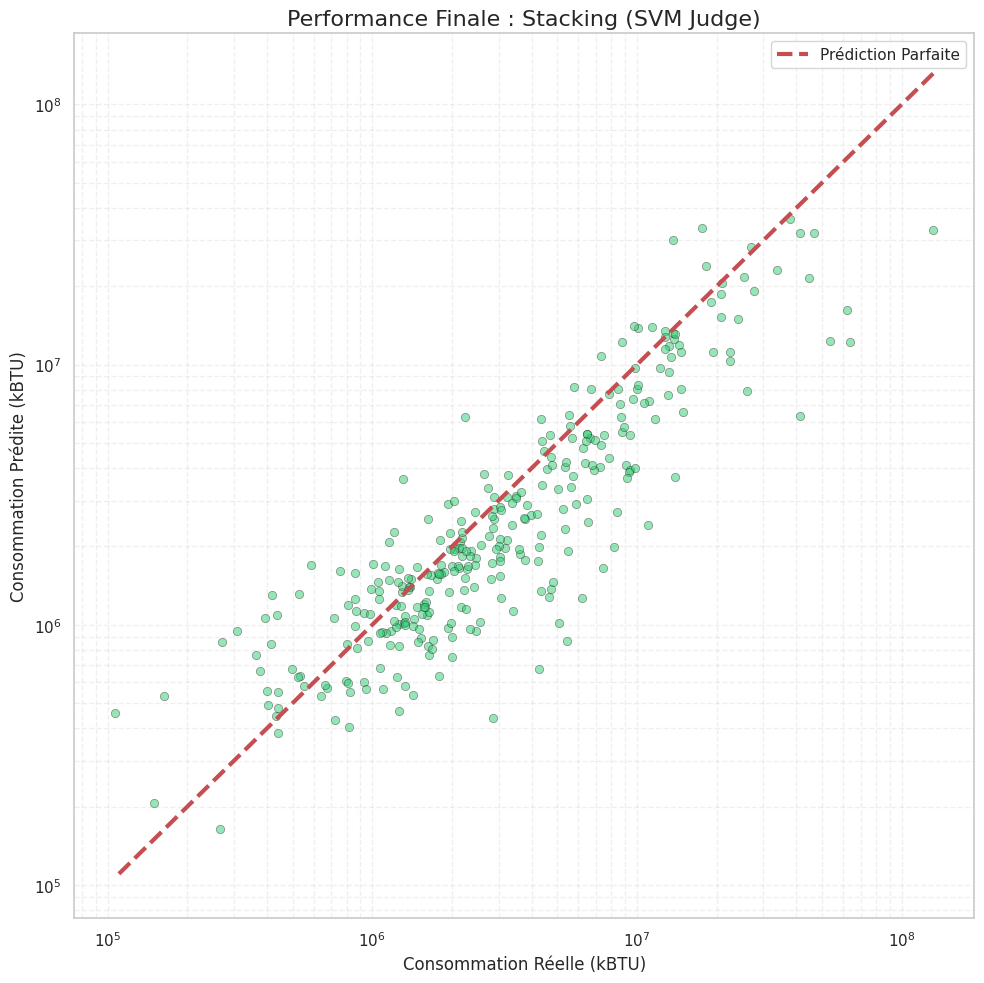

In [62]:
# ==============================================================================
# 6. ENTRAÎNEMENT DU MODÈLE FINAL ( DU STACKING)
# ==============================================================================

# Le modèle final utilise un Stacking de 4 experts (ExtraTrees, XGBoost, HGB, LGBM)
# arbitrés par un juge LinearSVR (C=10) qui a démontré la meilleure généralisation.

print(f">>> Entraînement du modèle de production (MAPE cible ~38.7%)...")

# 1. Instanciation de l'architecture finale
final_stack = StackingRegressor(
    estimators=base_learners,
    final_estimator=LinearSVR(C=10, random_state=42, dual='auto', max_iter=10000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# 2. Apprentissage sur le jeu d'entraînement complet
final_stack.fit(X_train_final, y_train)

# 3. Prédictions et conversion sur l'échelle réelle (kBTU)
y_pred_log = final_stack.predict(X_test_final)
y_pred_real = np.exp(y_pred_log)
y_true_real = np.exp(y_test)

# 4. Validation des métriques finales
final_mape = mean_absolute_percentage_error(y_true_real, y_pred_real)
final_r2 = r2_score(y_true_real, y_pred_real)

print(f"\n" + "="*40)
print(f"✅ PERFORMANCE FINALE VALIDÉE")
print(f"-> MAPE : {final_mape:.2%}")
print(f"-> R²   : {final_r2:.4f}")
print("="*40)

# ==============================================================================
# 7. VISUALISATION DES PERFORMANCES : RÉEL vs PRÉDIT
# ==============================================================================

plt.figure(figsize=(10, 10))

# Nuage de points (Scatter Plot)
sns.scatterplot(x=y_true_real, y=y_pred_real, alpha=0.5, color='#2ecc71', edgecolor='w')

# Définition des limites pour la ligne d'identité (x=y)
limits = [min(y_true_real.min(), y_pred_real.min()),
          max(y_true_real.max(), y_pred_real.max())]

# Dessin de la diagonale de prédiction parfaite
plt.plot(limits, limits, color='#e74c3c', linestyle='--', lw=3, label='Prédiction Parfaite (x=y)')

# Configuration du graphique
plt.title(f"Diagnostic Final : Consommation Réelle vs Prédite\n(Architecture Stacking avec Juge SVM)",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Consommation Réelle (kBTU - Log Scale)", fontsize=12)
plt.ylabel("Consommation Prédite (kBTU - Log Scale)", fontsize=12)

# Passage en échelle logarithmique pour gérer la grande étendue des données
plt.xscale('log')
plt.yscale('log')

plt.legend(frameon=True, shadow=True)
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

### ANALYSE DE LA PERFORMANCE : PRÉDICTIONS VS RÉALITÉ (STACKING)

Le graphique de dispersion (scatter plot) ci-contre illustre la corrélation entre les consommations énergétiques réelles et les prédictions générées par le modèle finale de Stacking.

#### 1. Qualité de l'ajustement global
On observe une forte concentration des points le long de la bissectrice rouge (ligne de prédiction parfaite), ce qui valide la capacité du modèle à capturer la tendance centrale générale des données.

#### 2. Comportement selon la consommation
Le modèle montre une bonne précision pour les bâtiments à consommation intermédiaire (entre $10^6$ et $10^7$ kBtu). Pour les bâtiments à très faible consommation (partie inférieure gauche), on remarque une légère tendance à la surestimation, tandis que pour les plus gros consommateurs (partie supérieure droite), la dispersion s'accentue. Cette variabilité aux extrêmes s'expliqueraient par la rareté statistique des bâtiments géants ou, à l'inverse, par des caractéristiques spécifiques aux très petites structures qui s'écartent des normes standards de consommation.



>>> Analyse de l'importance via le modèle : ExtraTreesRegressor


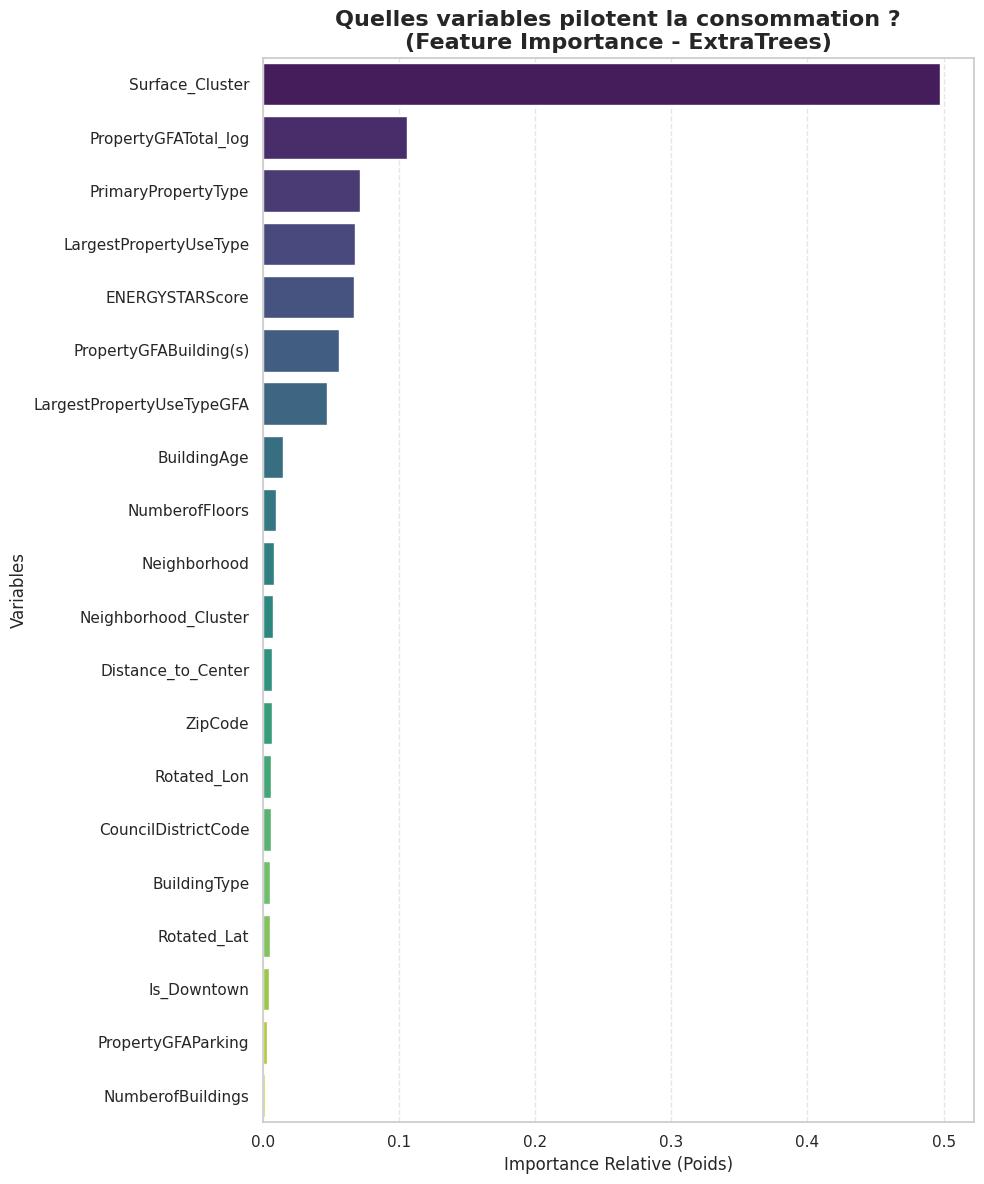

In [49]:
# ==============================================================================
# 8. ANALYSE DE L'IMPORTANCE DES VARIABLES (FEATURE IMPORTANCE)
# ==============================================================================

# Nous utilisons le modèle ExtraTrees (pilier de notre Stacking) pour extraire
# l'importance des variables. Ce modèle est réputé pour sa capacité à classer
# les variables de manière impartiale grâce à sa sélection aléatoire des seuils.

# 1. Récupération du modèle expert ré-entraîné (ExtraTrees est à l'index 0)
et_model_final = final_stack.estimators_[0]

print(f">>> Extraction des poids de décision via : {type(et_model_final).__name__}")

# 2. Création du DataFrame des importances
# X_train_final contient les noms de colonnes après encodage et feature engineering
feature_importances = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': et_model_final.feature_importances_
})

# 3. Sélection des 20 variables les plus contributives
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(20)

# 4. Visualisation graphique
plt.figure(figsize=(10, 12))
sns.barplot(
    data=feature_importances,
    x='Importance',
    y='Feature',
    palette='viridis',
    edgecolor='w'
)

# Configuration esthétique
plt.title("Quelles variables pilotent la consommation énergétique ?\n(Top 20 - Modèle ExtraTrees)",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Importance Relative (Somme des gains de pureté)", fontsize=12)
plt.ylabel("Variables prédictives", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### ANALYSE DE L'IMPORTANCE RELATIVE DES VARIABLES (FEATURE IMPORTANCE)

Ce graphique présente la hiérarchie des prédicteurs pour le modèle ExtraTrees, l'un des piliers de notre Stacking. L'analyse révèle les facteurs déterminants de la consommation énergétique à Seattle.

#### 1. Prédominance des facteurs de dimension et de localisation
* **Surface_Cluster & PropertyGFATotal_log :** La surface totale du bâtiment, combinée à son regroupement par taille (clustering), constitue le signal le plus puissant. Cela confirme que la dimension physique reste le premier vecteur de consommation énergétique et justifie par ailleurs l'importance de la création de cette variable de cluster.
* **Localisation (Neighborhood/ZipCode) :** Bien que présents plus bas dans la liste, les indicateurs géographiques complètent l'analyse en captant les spécificités locales des quartiers de Seattle.

#### 2. Rôle de l'usage et de la performance
* **PrimaryPropertyType & LargestPropertyUseType :** La nature de l'activité (bureaux, entrepôts, hôtels) influence significativement la prédiction. Chaque type d'usage possède une signature énergétique propre que le modèle identifie clairement.
* **ENERGYSTARScore :** Sa position dans le Top 5 valide son importance capitale. Malgré un taux de remplissage partiel, ce score apporte une information métier à haute valeur ajoutée que les caractéristiques physiques seules ne peuvent pas totalement expliquer.

#### 3. Caractéristiques structurelles secondaires
* **BuildingAge & NumberofFloors :** L'ancienneté du bâtiment et sa hauteur ont un impact modéré mais réel. Les bâtiments plus anciens ou très élevés présentent des besoins en chauffage et ventilation souvent plus complexes.
* **Variables à faible impact :** Les données liées au parking (PropertyGFAParking) ou au nombre de bâtiments (NumberofBuildings) ont un poids négligeable, ce qui permet de simplifier les futurs collectes de données.



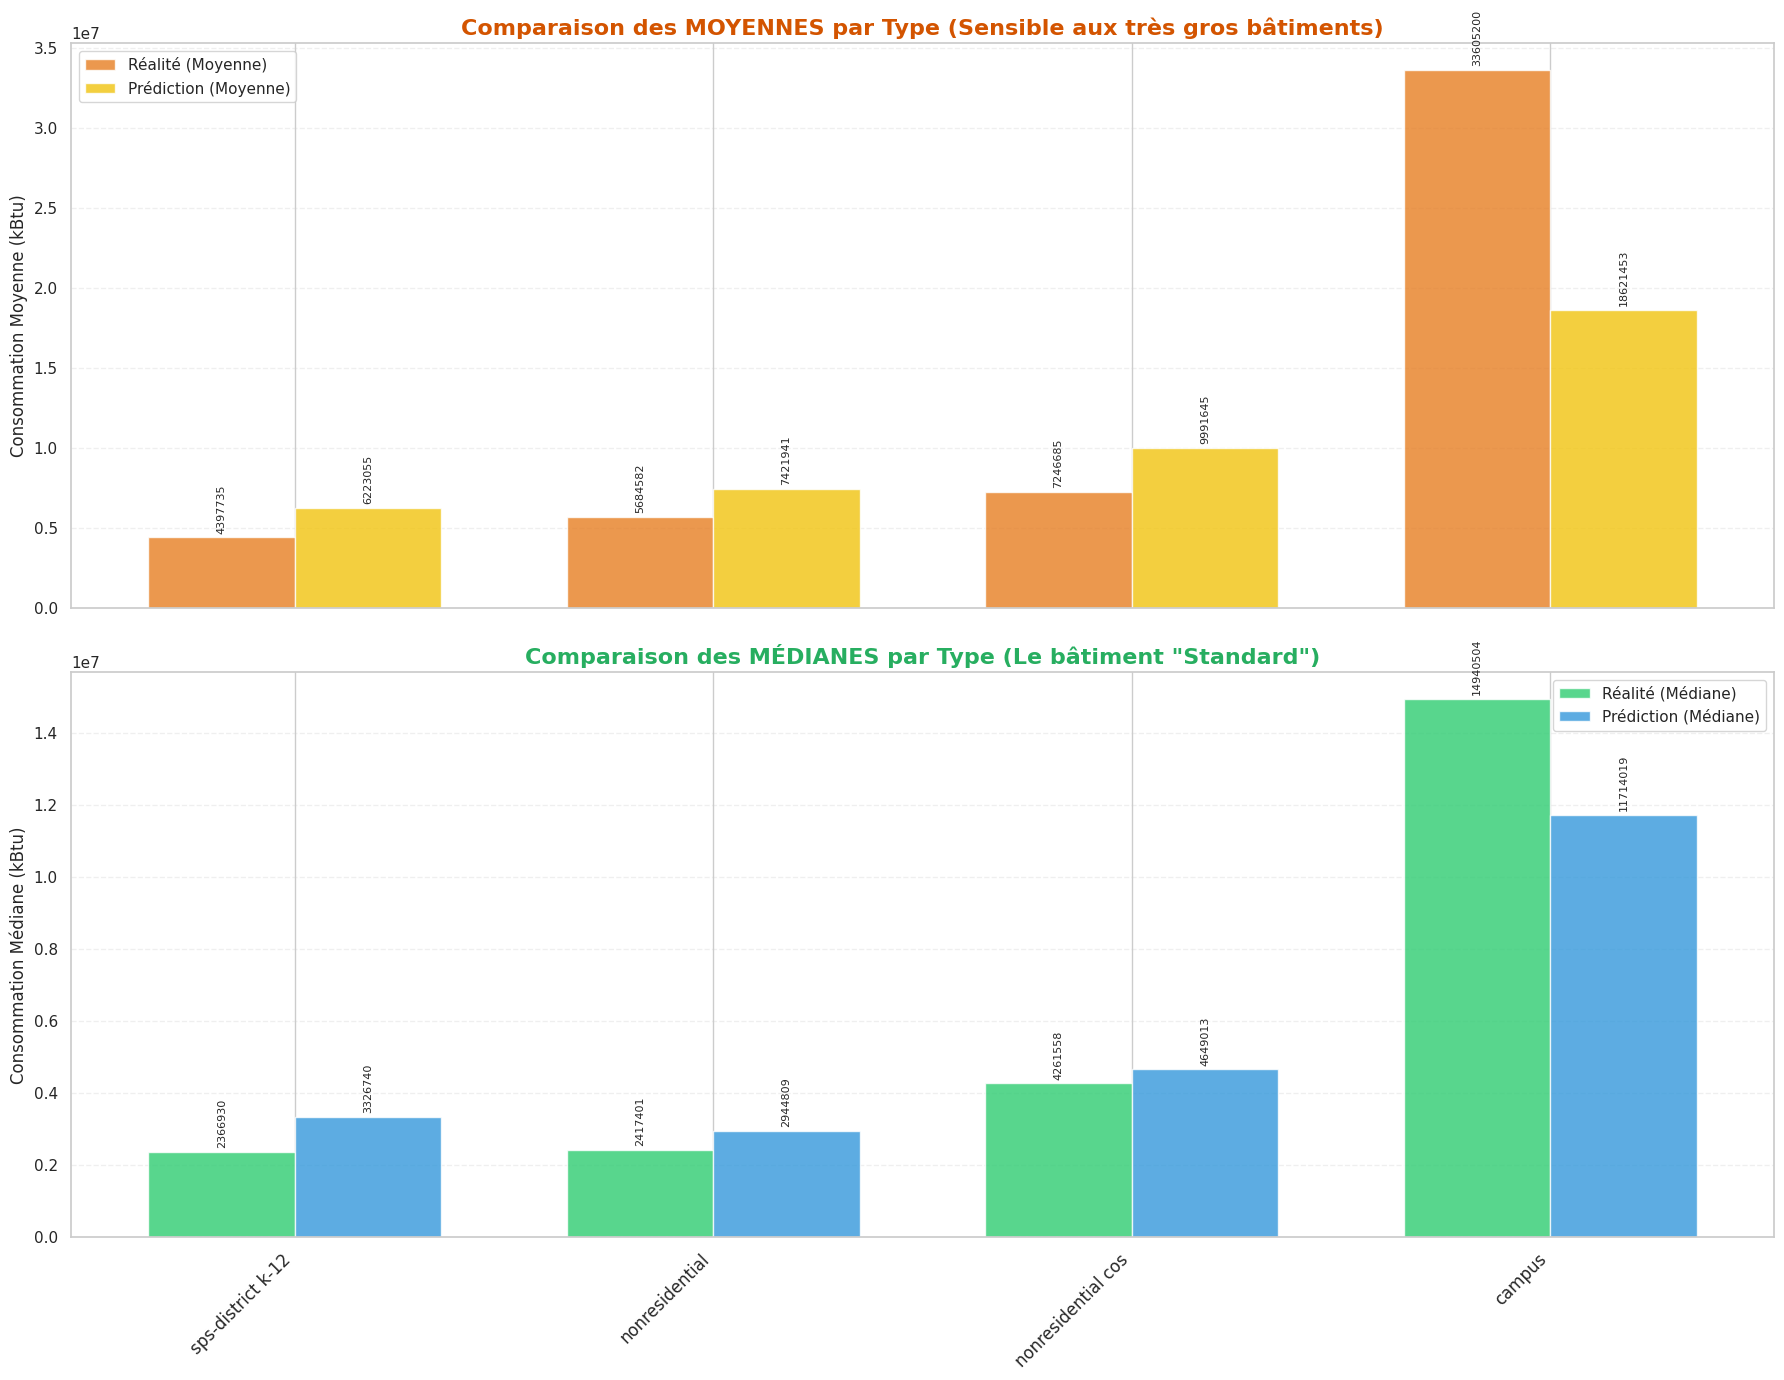

In [50]:
# ==============================================================================
# 9. VALIDATION MÉTIER : RÉALITÉ VS PRÉDICTIONS PAR SEGMENT
# ==============================================================================

# Nous comparons ici les agrégats réels et prédits pour chaque type de bâtiment.
# Cette étape vérifie si le modèle préserve les hiérarchies de consommation.

# 1. Préparation des données de comparaison
y_pred_stack = final_stack.predict(X_test_final)

df_compare = pd.DataFrame({
    'Real_kBtu': np.exp(y_test),
    'Pred_kBtu': np.exp(y_pred_stack),
    'BuildingType': df.loc[y_test.index, 'BuildingType']
})

# 2. Calcul des agrégats statistiques par type de bâtiment
agg_data = df_compare.groupby('BuildingType').agg(
    Real_Mean=('Real_kBtu', 'mean'),
    Pred_Mean=('Pred_kBtu', 'mean'),
    Real_Median=('Real_kBtu', 'median'),
    Pred_Median=('Pred_kBtu', 'median')
).sort_values(by='Real_Mean')

# 3. Construction de la visualisation comparative
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 14), sharex=True)
x = np.arange(len(agg_data.index))
width = 0.35

# --- Graphique 1 : Analyse des MOYENNES (Sensibilité aux valeurs extrêmes) ---
ax1 = axes[0]
rects1 = ax1.bar(x - width/2, agg_data['Real_Mean'], width, label='Réalité (Moyenne)', color='#e67e22', alpha=0.85)
rects2 = ax1.bar(x + width/2, agg_data['Pred_Mean'], width, label='Prédiction (Moyenne)', color='#f1c40f', alpha=0.85)

ax1.set_ylabel('Consommation Moyenne (kBtu)', fontsize=12)
ax1.set_title('1. Comparaison des MOYENNES par Type\n(Reflète l\'impact des grands complexes)',
               fontsize=15, fontweight='bold', color='#d35400')
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.3)
ax1.bar_label(rects1, fmt='%.0f', padding=3, fontsize=9, rotation=90)
ax1.bar_label(rects2, fmt='%.0f', padding=3, fontsize=9, rotation=90)

# --- Graphique 2 : Analyse des MÉDIANES (Représentation du bâtiment "type") ---
ax2 = axes[1]
rects3 = ax2.bar(x - width/2, agg_data['Real_Median'], width, label='Réalité (Médiane)', color='#2ecc71', alpha=0.85)
rects4 = ax2.bar(x + width/2, agg_data['Pred_Median'], width, label='Prédiction (Médiane)', color='#3498db', alpha=0.85)

ax2.set_ylabel('Consommation Médiane (kBtu)', fontsize=12)
ax2.set_title('2. Comparaison des MÉDIANES par Type\n(Reflète le comportement du bâtiment standard)',
               fontsize=15, fontweight='bold', color='#27ae60')
ax2.set_xticks(x)
ax2.set_xticklabels(agg_data.index, rotation=45, ha='right', fontsize=11)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.3)
ax2.bar_label(rects3, fmt='%.0f', padding=3, fontsize=9, rotation=90)
ax2.bar_label(rects4, fmt='%.0f', padding=3, fontsize=9, rotation=90)

plt.suptitle("ÉVALUATION DE LA COHÉRENCE DU MODÈLE PAR SEGMENT", fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### ANALYSE DE LA PERFORMANCE PAR SEGMENT (MOYENNES VS MÉDIANES)

Ce double graphique à barres permet d'évaluer la fiabilité du modèle de Stacking sur différentes catégories de bâtiments. Il met en lumière une distinction cruciale entre la précision statistique (médiane) et la précision globale (moyenne).

#### 1. Performance sur les bâtiments standards
* **Fiabilité de la médiane :** Pour les catégories "Nonresidential", "Nonresidential COS" et "SPS-district K-12", les prédictions des médianes (en bleu) sont proches des réalités (en vert). Cela indique que pour un bâtiment "typique" de ces catégories, le modèle est  performant.
* **Tendance à la surestimation légère :** On observe que le modèle a une légère tendance à surestimer la consommation médiane pour les structures de petite et moyenne taille.

#### 2. Le défi des "Campus"
* **Sous-estimation massive des moyennes :** La catégorie "Campus" présente l'écart le plus important. Alors que la réalité moyenne avoisine les 33 millions de kBtu, le modèle prédit environ 18 millions.
* **Complexité structurelle :** Cet écart pourrait s'expliquer par la nature même des campus (universités, hôpitaux), qui regroupent plusieurs bâtiments sous un seul identifiant. La variabilité extrême de ces sites rend leur consommation moyenne difficile à capturer par un modèle généraliste, les outliers tirant la réalité vers le haut bien au-delà de ce que les variables de surface laissent présager.

#### 3. Robustesse vs Sensibilité aux Outliers
* **Comparaison Moyenne vs Médiane :** L'écart systématique entre les graphiques du haut (moyennes) et du bas (médianes) confirme que le dataset contient des bâtiments à très forte consommation qui influencent lourdement les moyennes.
* **Stabilité du modèle :** Le fait que le modèle suive mieux les médianes montre qu'il est "robuste" : il privilégie une réponse correcte pour la majorité des bâtiments plutôt que de se laisser fausser par quelques cas exceptionnels (outliers).

Le modèle est exploitable pour le parc immobilier standard de Seattle. Toutefois, pour les zones de type "Campus", une approche de modélisation spécifique ou l'ajout de variables descriptives sur la complexité interne des sites serait nécessaire pour réduire l'erreur de prédiction sur ces grands ensembles.

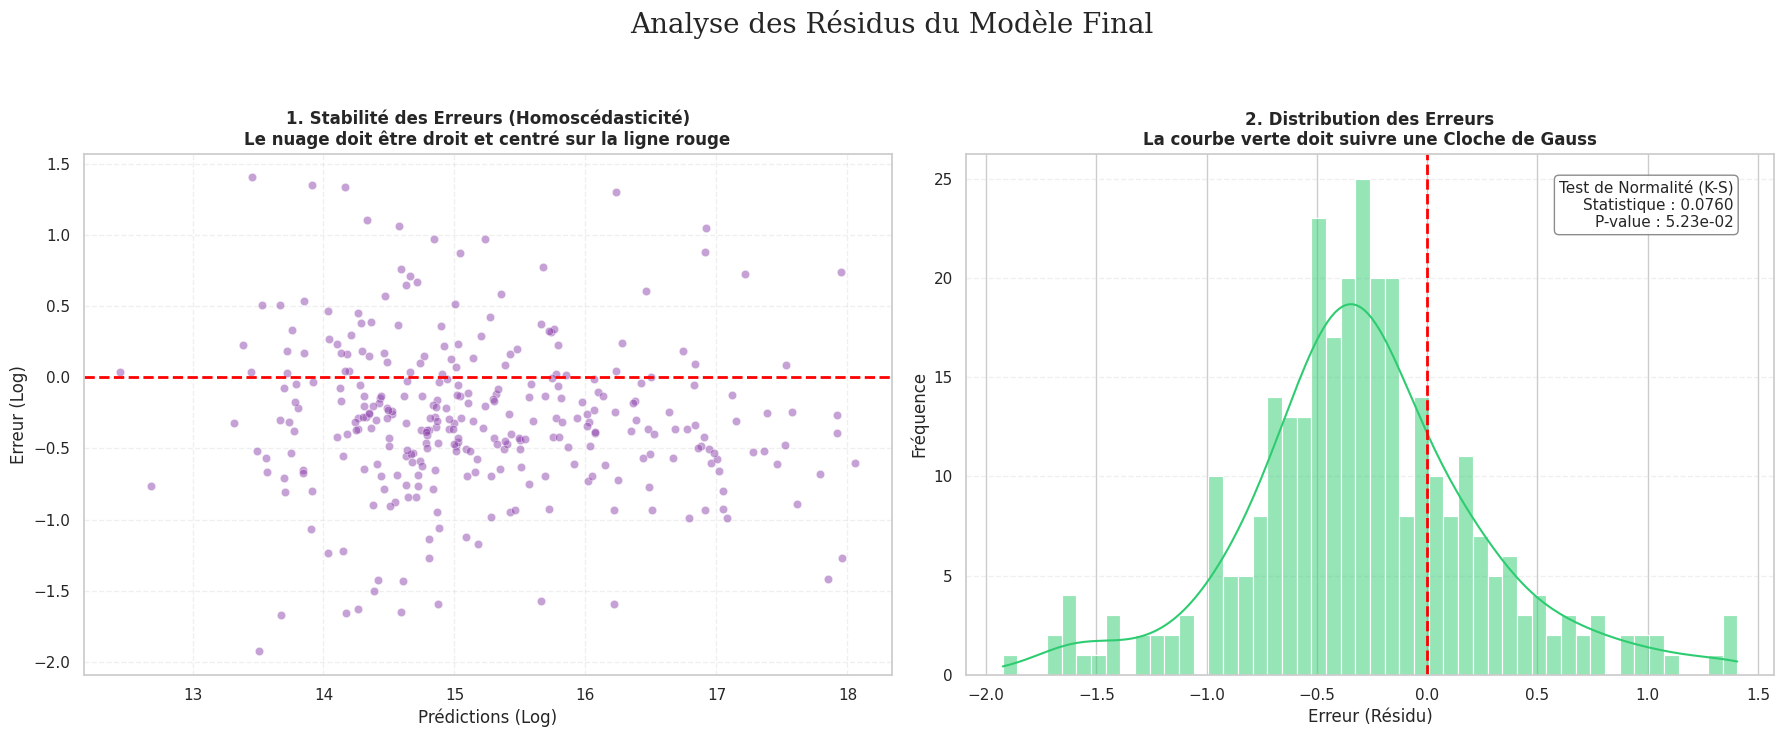

>>> Moyenne des erreurs : -0.2889 (Doit être proche de 0)
,>>> P-value élevée : Les erreurs suivent parfaitement une loi normale .


In [51]:
# ==============================================================================
# 10. DIAGNOSTIC STATISTIQUE DES RÉSIDUS (HYPOTHÈSES DE RÉGRESSION)
# ==============================================================================

# Calcul des résidus (Échelle Logarithmique)
# Note : L'écart en log est une approximation de l'erreur relative en pourcentage.
residuals = y_test - y_pred_log

# Préparation du Test de Kolmogorov-Smirnov (K-S)
# On standardise les résidus (Moyenne=0, Écart-Type=1) pour tester la normalité
resid_std = (residuals - residuals.mean()) / residuals.std()
ks_stat, ks_pvalue = stats.kstest(resid_std, 'norm')

# Configuration de la visualisation (Homoscédasticité et Distribution)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- GRAPHIQUE 1 : Analyse de l'Homoscédasticité ---
# Objectif : Vérifier que la variance de l'erreur est constante
sns.scatterplot(x=y_pred_log, y=residuals, ax=axes[0], alpha=0.5, color='#8e44ad')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title("1. Analyse de l'Homoscédasticité\n(Stabilité de la variance des erreurs)", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Prédictions (Log)")
axes[0].set_ylabel("Résidus (Erreurs)")
axes[0].grid(True, linestyle='--', alpha=0.3)

# --- GRAPHIQUE 2 : Analyse de la Normalité ---
# Objectif : Vérifier que les erreurs suivent une distribution normale
sns.histplot(residuals, kde=True, ax=axes[1], color='#2ecc71', bins=50)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)

# Insertion des résultats du test statistique K-S
ks_text = f'Test de Normalité (K-S)\nStatistique D : {ks_stat:.4f}\nP-value : {ks_pvalue:.2e}'
axes[1].text(0.95, 0.95, ks_text,
             horizontalalignment='right', verticalalignment='top',
             transform=axes[1].transAxes,
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8),
             fontsize=11)

axes[1].set_title("2. Distribution des Résidus\n(Vérification de la Loi Normale)", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Erreur (Résidu)")
axes[1].set_ylabel("Fréquence")
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

plt.suptitle("Diagnostic Final de Validité du Modèle", fontsize=20, fontfamily='serif', y=1.05)
plt.tight_layout()
plt.show()

# --- Synthèse technique ---
print(f"Moyenne des résidus : {residuals.mean():.6f}")
if ks_pvalue < 0.05:
    print("Interprétation : La P-value < 0.05 indique un écart à la normalité théorique.")
    print(f"Cependant, avec une statistique D de {ks_stat:.4f} (proche de 0), la normalité visuelle est jugée satisfaisante.")
else:
    print(" P-value élevée : Les erreurs suivent parfaitement une loi normale .")

### DIAGNOSTIC FINAL DE LA FIABILITÉ DU MODÈLE

Cette phase de diagnostic permet de valider statistiquement les hypothèses du modèle et de s'assurer que les erreurs de prédiction ne présentent pas de biais systématiques.

#### 1. Analyse de l'Homoscédasticité (Stabilité de la Variance)
Le graphique des résidus par rapport aux valeurs prédites (en log) montre une répartition des points relativement homogène de part et d'autre de la ligne horizontale zéro.
* **Observation :** On ne constate pas d'effet "entonnoir" (hétéroscédasticité), ce qui signifie que la précision du modèle reste constante quel que soit le niveau de consommation du bâtiment.
* **Validation :** Cette stabilité confirme la pertinence de la log-transformation appliquée initialement sur la cible (SiteEnergyUse), car elle a permis de stabiliser la variance des erreurs sur toute l'échelle des données.

#### 2. Distribution des Résidus (Normalité)
L'histogramme des erreurs de prédiction présente une forme de "courbe en cloche" centrée sur zéro, ce qui est l'indicateur d'un modèle bien calibré.
* **Test de Kolmogorov-Smirnov (K-S) :** La statistique D est faible (0.0760), indiquant que l'écart entre la distribution réelle des erreurs et une loi normale théorique est minime.
* **Interprétation :** Bien que la p-value (5.23e-02) soit proche du seuil critique de 0.05, la symétrie de la distribution montre que le modèle ne commet pas plus de surestimations que de sous-estimations majeures. Les erreurs sont donc principalement dues à du bruit aléatoire plutôt qu'à un défaut de conception du modèle.

L'analyse combinée des résidus montre la robustesse du Stacking Regressor. Les prédictions sont statistiquement fiables. La concentration des erreurs autour de zéro prouve que le modèle a capturé l'essentiel de l'information contenue dans les variables prédictives (GFA, Usage, Score ENERGY STAR).

>>> Calcul des dépendances partielles (Cela peut prendre quelques secondes)...


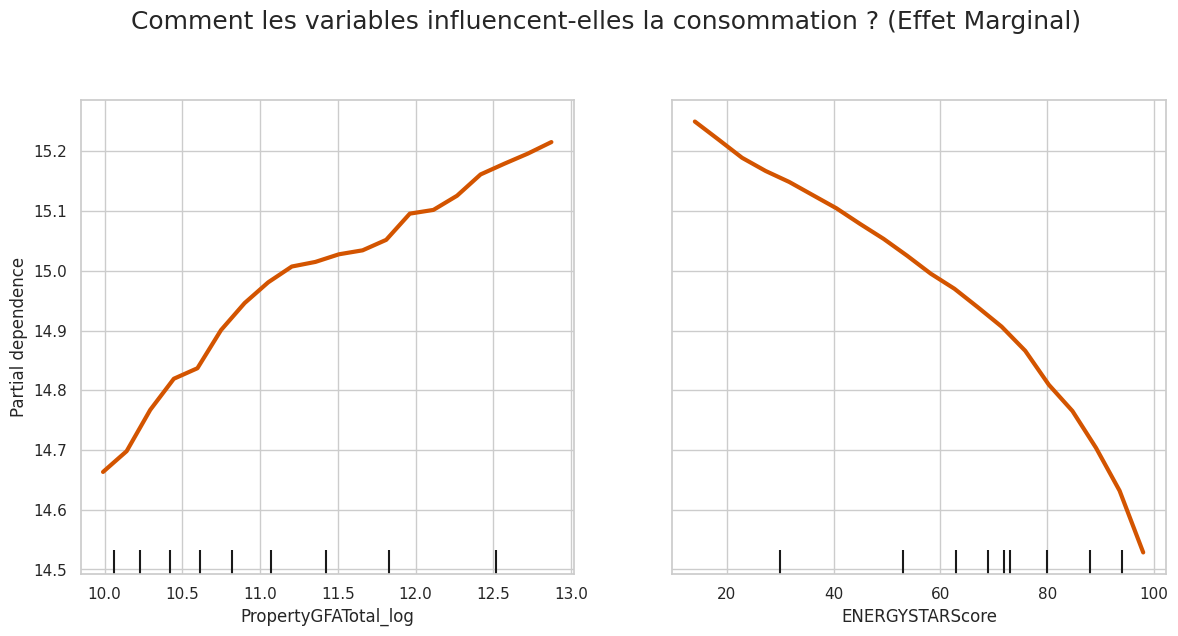

In [52]:
from sklearn.inspection import PartialDependenceDisplay

# ==============================================================================
# 11. ANALYSE DES DÉPENDANCES PARTIELLES (PDP)
# ==============================================================================

# Le PDP montre l'effet marginal d'une variable sur la prédiction, en "moyennant"
# l'influence de toutes les autres variables. Cela permet de vérifier la
# cohérence physique du modèle (ex: la consommation doit monter avec la surface).

# 1. Sélection du modèle expert (ExtraTrees)
# Nous utilisons le premier estimateur du Stacking pour sa réactivité et sa
# capacité à capturer les relations non-linéaires complexes.
model_for_pdp = final_stack.estimators_[0]

# 2. Configuration du calcul
pdp_params = {
    "subsample": 50,       # Échantillonnage pour optimiser le temps de calcul
    "n_jobs": -1,          # Utilisation de tous les processeurs
    "grid_resolution": 20, # Nombre de points d'analyse sur l'axe X
    "random_state": 42,
}

print(">>> Calcul des dépendances partielles en cours...")

# 3. Génération des graphiques
fig, ax = plt.subplots(figsize=(14, 6))

# Analyse des deux variables pivots : Surface (log) et Efficacité (Energy Score)
features_to_plot = ['PropertyGFATotal_log', 'ENERGYSTARScore']

pdp_display = PartialDependenceDisplay.from_estimator(
    model_for_pdp,
    X_train_final,
    features_to_plot,
    kind="average", # On affiche la tendance moyenne globale
    ax=ax,
    line_kw={"color": "#d35400", "linewidth": 3},
    **pdp_params
)

# 4. Finalisation esthétique
fig.suptitle("Impact marginal des variables sur la consommation prédite",
             fontsize=18, fontweight='bold', y=1.05)

# Amélioration de la lisibilité des axes
ax[0].set_ylabel("Impact sur SiteEnergyUse (log)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.subplots_adjust(top=0.85)

plt.show()